In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog
from skimage import color, exposure
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# if you are using scikit-learn >= 0.18 then use this:
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Display car images

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


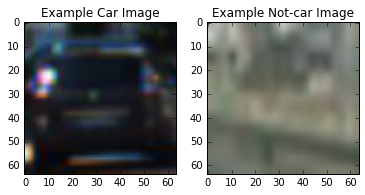

In [2]:
# images are divided up into vehicles and non-vehicles

notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')
cars = glob.glob('vehicles_smallset/*/*.jpeg')

        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

## Extract HOG feature

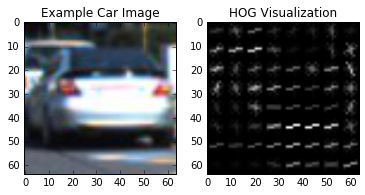

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        hog_features =[]
        img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        for channel in range(img.shape[2]):
            features = hog(img[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
            hog_features.append(features)
        hog_features = np.ravel(hog_features)
        return hog_features
    
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(image, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Spatial binning of colors

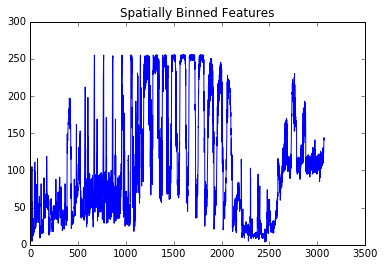

In [4]:
def bin_spatial(img, color_space='YCrCb', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))
# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

## Color Histogram

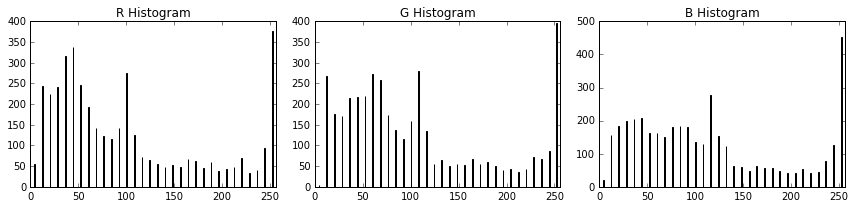

In [5]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features
    

rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

## Combine features

1196


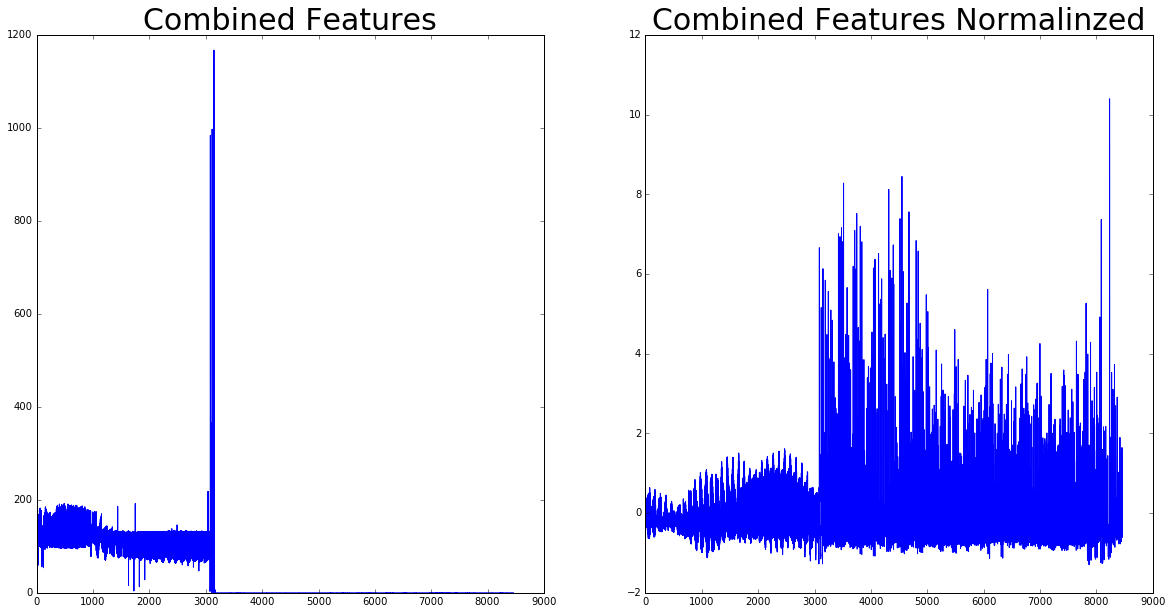

In [6]:
cars = glob.glob('vehicles_smallset/*/*.jpeg')
notcars = glob.glob('non-vehicles_smallset/*/*.jpeg')
print(len(cars))

def extract_features(imgs, cspace='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient = 9,
                        pix_per_cell = 8,
                        cell_per_block = 2,
                        nbins=32, 
                        bins_range=(0, 256)):
    features = []
    for file in imgs:
        image = mpimg.imread(file)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(image, color_space=cspace, size=spatial_size)
        # color hist 
        rh, gh, bh, bincen, hist_features = color_hist(image, nbins=nbins, bins_range=bins_range)
        # HOG feature 
        hog_features = get_hog_features(image, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True)
#         print("spatial features: " + str(spatial_features.shape))
#         print("hist features: " + str(hist_features.shape))
#         print("hog features: " + str(hog_features.shape))
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    return features


car_features = extract_features(cars)
notcar_features = extract_features(notcars)
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# print(len(car_features))


car_ind = np.random.randint(0, len(cars))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(notcar_features[car_ind])
ax1.set_title('Combined Features', fontsize=30)
ax2.plot(scaled_X[car_ind + 397])
ax2.set_title('Combined Features Normalinzed', fontsize=30)

In [7]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

In [8]:
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 8460
0.73 Seconds to train SVC...
Test Accuracy of SVC =  0.9935
My SVC predicts:  [ 0.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
For these 10 labels:  [ 0.  1.  1.  0.  0.  1.  0.  1.  1.  1.]
0.00215 Seconds to predict 10 labels with SVC


## Sliding window search

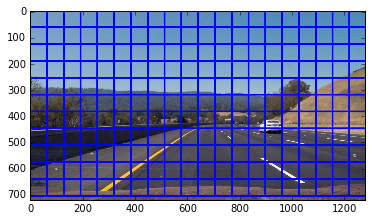

In [9]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
#         print(imcopy, bbox[0], bbox[1], color, thick)
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

image = mpimg.imread('test_images/test3.jpg')
windows = slide_window(image)
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Compute features of each window and make prediction

In [10]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='YCrCb', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient = 9,
                        pix_per_cell = 8,
                        cell_per_block = 2,
                        nbins=32, 
                        bins_range=(0, 256)):
    
    spatial_features = bin_spatial(image, size=spatial_size)
    # color hist 
    rh, gh, bh, bincen, hist_features = color_hist(image, nbins=nbins, bins_range=bins_range)
    # HOG feature 
    hog_features = get_hog_features(image, orient, 
                            pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True)
    return np.concatenate((spatial_features, hist_features, hog_features))


# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

## Multi scale window search

720 1280


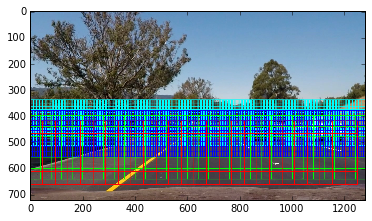

In [36]:
height = image.shape[0]
width = image.shape[1]
print(height, width)
xxs_windows = slide_window(image, x_start_stop=[0, width], y_start_stop=[340, 520], xy_window=(64, 64), xy_overlap=(0.8, 0.8))
# xs_windows = slide_window(image, x_start_stop=[600, width], y_start_stop=[350, 520], xy_window=(96, 96), xy_overlap=(0.75, 0.75))
s_windows = slide_window(image, x_start_stop=[0, width], y_start_stop=[380, 560], xy_window=(100, 100), xy_overlap=(0.9, 0.8))
m_windows = slide_window(image, x_start_stop=[0, width], y_start_stop=[400, 640], xy_window=(160, 160), xy_overlap=(0.75, 0.75))
l_windows = slide_window(image, x_start_stop=[0, width], y_start_stop=[420, 700], xy_window=(192, 192), xy_overlap=(0.75, 0.75))

window_img = draw_boxes(image, xxs_windows, color=(0, 255, 255), thick=2)  
# window_img = draw_boxes(window_img, xs_windows, color=(255, 255, 255), thick=2)   
window_img = draw_boxes(window_img, s_windows, color=(0, 0, 255), thick=2)     
window_img = draw_boxes(window_img, m_windows, color=(0, 255, 0), thick=2)     
window_img = draw_boxes(window_img, l_windows, color=(255, 0, 0), thick=2)     

plt.imshow(window_img)



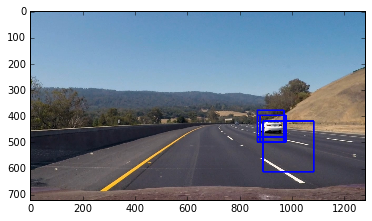

In [25]:
draw_image = np.copy(image)
windows = xxs_windows + s_windows + m_windows + l_windows
hot_windows = search_windows(image, windows, svc, X_scaler)                     
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Eliminate false positives

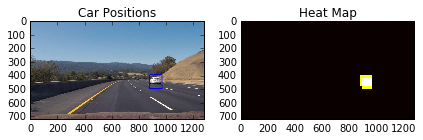

In [26]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat, 2)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Video process pipline

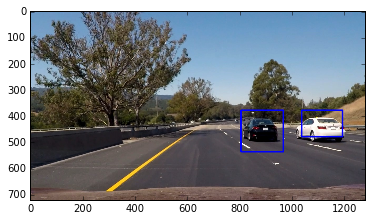

In [33]:
from collections import deque
global history
history = deque(maxlen = 8)

def pipeline(image):
    global history
    draw_image = np.copy(image)
    windows = xxs_windows + s_windows + m_windows + l_windows
    hot_windows = search_windows(image, windows, svc, X_scaler)                      
    zero_heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    current_heat = add_heat(zero_heat,hot_windows)
    history.append(current_heat)
    heat_avg = sum(history) / len(history)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat_avg, 2)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img

history.clear()
image = mpimg.imread('test_images/test6.jpg')
result = pipeline(image)
plt.imshow(result)

In [34]:
history.clear()
new_clip_output = 'output2.mp4'
test_clip = VideoFileClip("project_video.mp4")
new_clip = test_clip.fl_image(pipeline) #NOTE: this function expects color images!!
%time new_clip.write_videofile(new_clip_output, audio=False)

[MoviePy] >>>> Building video output2.mp4
[MoviePy] Writing video output2.mp4


100%|█████████▉| 1260/1261 [1:07:32<00:03,  3.21s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output2.mp4 

CPU times: user 2h 12min 22s, sys: 1min 11s, total: 2h 13min 34s
Wall time: 1h 7min 33s
